In [1]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt  # опционально, нужно только для проверки содержимого
from osgeo import osr, gdal

#### Пути ввода/вывода:

In [2]:
# сначала придётся пересохранить экселевский лист с данными в файл csv (разделитель - точка с запятой):
# in_path = "/home/antonv/PycharmProjects/lena/data/12.06.2020.csv"
in_path = "/home/antonv/PycharmProjects/lena/data/2020.csv"

out_path = "%s.tif" % os.path.splitext(in_path)[0]

#### Загрузим и проверим содержимое:

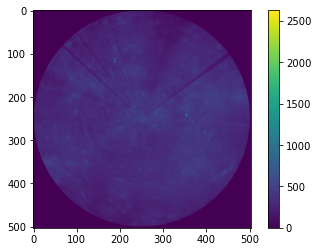

In [3]:
df = pd.read_csv(in_path, decimal=",", sep=";", dtype=float)  # после ключевого слова sep можно поменять разделитель ячеек
arr = df.to_numpy()

plt.imshow(arr)
plt.colorbar()
plt.show()

#### Экспортируем в привязанный GeoTIFF:

In [4]:
# 1) создаём массив для привязки изображения в формате GDAL GeoTransform:
"""
GDAL GeoTransform:
GT(0) x-coordinate of the upper-left corner of the upper-left pixel.
GT(1) w-e pixel resolution / pixel width.
GT(2) row rotation (typically zero).
GT(3) y-coordinate of the upper-left corner of the upper-left pixel.
GT(4) column rotation (typically zero).
GT(5) n-s pixel resolution / pixel height (negative value for a north-up image).
"""
x_radar = 516406.28  # WGS84/UTM zone 36N
y_radar = 6423566.83

s = arr.shape
if s[1] == 504:
    px = 504
    res = 1000  # grid resolution in meters
elif s[1] == 252:
    px = 252
    res = 2000
else:
    raise ValueError("Unknown raster size - %sx%s" % s)

xul = x_radar - px / 2 * res
yul = y_radar + px / 2 * res

gt = [xul, res, 0, yul, 0, -res]  # GeoTransform готов

# 2) вызываем драйвер GTiff и просим его создать нам новый файл нужного размера с одним растровым каналом:
driver = gdal.GetDriverByName('GTiff')
rows, cols = s
no_bands = 1
# ds = driver.Create(out_path, cols, rows, no_bands, gdal.GDT_Byte)
ds = driver.Create(out_path, cols, rows, no_bands, gdal.GDT_Int16)

# 3) записываем в файл массив измерений, значение "нет данных" и геотрансформ:
ds.GetRasterBand(1).WriteArray(arr)
ds.GetRasterBand(1).SetNoDataValue(0)
ds.SetGeoTransform(gt)

# 4) прикрепляем к файлу информацию о системе координат:
srs = osr.SpatialReference()
srs.ImportFromEPSG(32636)  # UTM zone 36N
ds.SetProjection(srs.ExportToWkt())

# 5) все операции до этого момента выполнялись в оперативной памяти
# запись на диск будет произведена только после выполнения следующих команд:
ds.FlushCache()
ds = None
